<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S12/EVA4_S12_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports
Importing necessary packages and modules

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [2]:
from google.colab import drive

drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
import os
os.chdir('./drive/My Drive/Colab Notebooks/S12/datasets/dogs/')

!ls

dogs_coco.json	dogs_csv.csv  dogs.json  dogs_json.json


Data Preparation
Parse the JSON file to obtain annotations.

JSON File Structure
The annotation file will be of COCO format and have the following structure

images

id: Image id
width: Width of the image
height: Height of the image
filename: Image file name
license: License id for the image
date_captured: Date of capture of the image


annotations

id: Annotation id
image_id: Id of the image the annotation is associated with
category_id: Id of the class the annotation belongs to
segmentation: (x, y) coordinates of the four corners of the bounding box
area: Area of the bounding box
bbox: (x, y) coordinate of the top-left corner and width and height of the bounding box
iscrowd: If the image has a crowd of objects denoted by this annotation

In [4]:
def load_json(path):
    """Read the input JSON file.

    Args:
        path (str): Path to the JSON file.
    
    Returns:
        Image annotations.
    """
    with open(path) as f:
        img_annotations = eval(f.read())
    return img_annotations

In [16]:
def fetch_data_points(img_annotations):
    """Fetch data points from the image
    annotations.

    Args:
        img_annotations (dict): Image annotations.
    
    Returns:
        Array containing data points.
    """
    data_points = []
    for annotation in img_annotations['annotations']:
        bbox = annotation['bbox']
        img = img_annotations['images'][int(annotation['image_id'])-1]

        # Normalize the height and width of the bounding box
        data_points.append((
            bbox[2] / img['width'],
            bbox[3] / img['height']
        ))
    return np.array(data_points)

In [17]:
import json

img_annotations = load_json('dogs_coco.json')
data_points = fetch_data_points(img_annotations)

Visualize Data
Display a scatter plot of the height and width of the normalized bounding boxes

Text(0, 0.5, 'height')

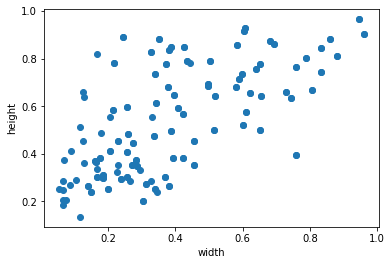

In [18]:
plt.scatter(data_points[:, 0], data_points[:, 1])
plt.xlabel('width')
plt.ylabel('height')

Text(0, 0.5, 'log(height)')

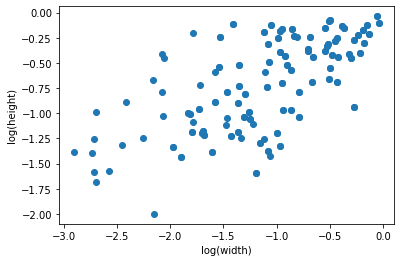

In [19]:
plt.scatter(np.log(data_points[:, 0]), np.log(data_points[:, 1]))
plt.xlabel('log(width)')
plt.ylabel('log(height)')

K-Means Clustering

Define the K-Means algorithm

In [23]:
def get_iou(centroids,closest,data_points):
  """Calculate Intersection over Union (IoU) for each point
  with its closest centroid."""
  closest_centroids = centroids[closest]
  width = np.minimum(closest_centroids[:, 0], data_points[:, 0])
  height = np.minimum(closest_centroids[:, 1], data_points[:, 1])

  intersection = width * height
  points_area = data_points[:, 0] * data_points[:, 1]
  cluster_area = closest_centroids[:, 0] * closest_centroids[:, 1]

  mean_iou = np.mean(intersection / (points_area + cluster_area - intersection))
  return mean_iou

In [24]:
from sklearn.cluster import KMeans
import numpy as np

# List containing the mean IoU for each set of
# number of clusters
iou_list = []

# Range of number of clusters to try out
num_clusters_start = 1
num_clusters_end = 16

# Run K-Means for each range of number of clusters
for k in range(num_clusters_start, num_clusters_end + 1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data_points)
    centroids=kmeans.cluster_centers_

    distances = np.sqrt(((data_points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    closest = np.argmin(distances, axis=0)
    iou_list.append(get_iou(centroids,closest,data_points))

Visualize Results
Display the Number of clusters vs Mean IoU graph

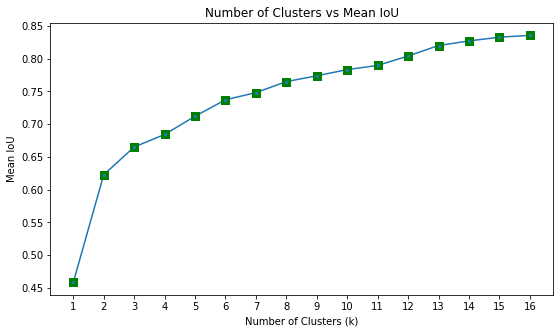

In [26]:
fig = plt.figure(figsize=(9, 5))

_ = plt.plot(iou_list, '-s', markeredgecolor='green', markeredgewidth=3)

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Mean IoU')

plt.xticks(np.arange(len(iou_list)), np.arange(1, len(iou_list)+1))
plt.title('Number of Clusters vs Mean IoU')

fig.savefig('kmeans_iou.png')

For the above plot, k = 3 or k = 4 seems to be the best choice because for after 4, the curve becomes almost linear.

Plot clusters
Let's display plots for points with k = 3 and k = 4

In [36]:
def display_clusters(kmeans,data_points):
    num_clusters = kmeans.n_clusters

    # Plot points for each cluster
    for cluster_id in range(num_clusters):
      distances = np.sqrt(((data_points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
      closest = np.argmin(distances, axis=0)

      points = data_points[closest == cluster_id]
      plt.scatter(points[:, 0], points[:, 1])
  
    # Plot centroids
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=90, marker='x')
    plt.xlabel('width')
    plt.ylabel('height')
    plt.title(f'Cluster Plot for k = {num_clusters}')

    # Save figure
    plt.savefig(f'cluster_plot_k{num_clusters}.png')

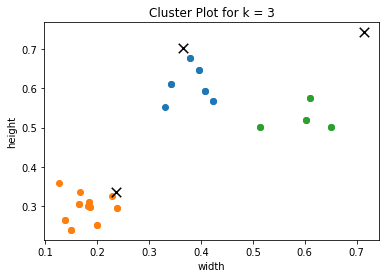

In [37]:
# Plot for k = 3
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_points)
display_clusters(kmeans,data_points)

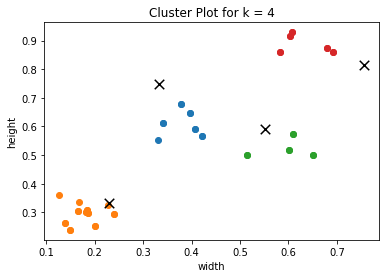

In [38]:
# Plot for k = 4
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_points)
display_clusters(kmeans,data_points)

Plot Anchor Boxes
Plot the anchor boxes obtained for k = 3 and k = 4

In [39]:
def make_anchor_boxes(ax, clusters, edgecolor='b', alpha=1):
    """Make anchor boxes given cluster centroids."""

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerror = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(clusters[:, 1])/2)]*2)

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(
        errorboxes, facecolor='None', alpha=alpha, edgecolor=edgecolor
    )

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(
        xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None'
    )

    return artists

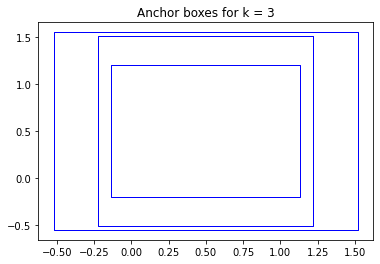

In [42]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Create error boxes
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_points)
_ = make_anchor_boxes(ax, kmeans.cluster_centers_)

# Show plot
plt.title('Anchor boxes for k = 3')
plt.show()
fig.savefig('anchor_bbox_k3.png')

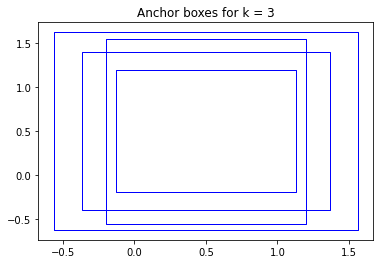

In [43]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Create error boxes
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_points)
_ = make_anchor_boxes(ax, kmeans.cluster_centers_)

# Show plot
plt.title('Anchor boxes for k = 3')
plt.show()
fig.savefig('anchor_bbox_k3.png')